# Environmental Sound Classification
Using concepts from Teachable Machine to build an audio classifier that recognizes different environmental sounds.

In [1]:
# Cell 1: Import necessary libraries for audio classification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

## Audio Feature Extraction
Functions to convert audio files into Mel Spectrograms - visual representations of audio that neural networks can process, similar to how Teachable Machine processes audio inputs.

In [2]:
# Cell 3: Define audio processing functions
def extract_features(file_path, duration=2.5, sr=22050):
    """Extract Mel Spectrogram features from an audio file"""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Generate Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )

        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

def visualize_audio_features(file_path, title="Mel Spectrogram"):
    """Visualize the audio features extracted from an audio file"""
    features = extract_features(file_path)

    if features is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            features,
            x_axis='time',
            y_axis='mel',
            sr=22050,
            hop_length=512
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

## Dataset Preparation
Using Google's Speech Commands dataset which contains spoken words like "yes", "no", "up", "down" - perfect for training a voice command recognizer.

In [4]:
# Cell 5: Use Google's Speech Commands dataset (which is more accessible)
!wget -q http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir -p speech_commands
!tar -xzf speech_commands_v0.01.tar.gz -C speech_commands

# Explore the dataset
import glob

# Get list of audio classes (directories)
class_dirs = [d for d in glob.glob('speech_commands/*') if os.path.isdir(d)]
class_names = [os.path.basename(d) for d in class_dirs]

# Count files per class
class_counts = {}
for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    class_counts[class_name] = len(glob.glob(f"{class_dir}/*.wav"))

# Print dataset info
print(f"Total classes: {len(class_names)}")
print(f"Classes: {', '.join(sorted(class_names)[:10])}...")  # Show first 10
print("\nSamples per class:")
for class_name, count in sorted(class_counts.items())[:10]:  # Show first 10
    print(f"{class_name}: {count}")

Total classes: 31
Classes: _background_noise_, bed, bird, cat, dog, down, eight, five, four, go...

Samples per class:
_background_noise_: 6
bed: 1713
bird: 1731
cat: 1733
dog: 1746
down: 2359
eight: 2352
five: 2357
four: 2372
go: 2372


## Data Processing
Converting audio to fixed-size Mel spectrograms to ensure consistent input dimensions for our neural network, targeting common voice commands.

In [6]:
# Cell 7: Prepare the dataset with fixed-size features
# Select a subset of classes to use (for faster training)
selected_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go']

# Fixed size for all spectrograms
def extract_fixed_features(file_path, duration=1.0, sr=22050, n_mels=128, time_steps=87):
    """Extract Mel Spectrogram features with fixed dimensions"""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Pad if too short
        if len(y) < sr * duration:
            y = np.pad(y, (0, int(sr * duration) - len(y)), 'constant')

        # Generate Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=2048,
            hop_length=512,
            n_mels=n_mels
        )

        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

        # Ensure fixed size - either crop or pad
        if log_mel_spectrogram.shape[1] > time_steps:
            log_mel_spectrogram = log_mel_spectrogram[:, :time_steps]
        elif log_mel_spectrogram.shape[1] < time_steps:
            padding = np.zeros((n_mels, time_steps - log_mel_spectrogram.shape[1]))
            log_mel_spectrogram = np.hstack((log_mel_spectrogram, padding))

        return log_mel_spectrogram
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Modified function to process audio files with fixed dimensions
def prepare_dataset(classes, max_per_class=100):
    features = []
    labels = []

    for class_name in classes:
        print(f"Processing class: {class_name}")
        class_path = f"speech_commands/{class_name}"
        files = glob.glob(f"{class_path}/*.wav")[:max_per_class]

        for file_path in files:
            mel_spectrogram = extract_fixed_features(file_path)

            if mel_spectrogram is not None:
                features.append(mel_spectrogram)
                labels.append(classes.index(class_name))

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Reshape for CNN input: (samples, height, width, channels)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)

    return features, labels

# Prepare the dataset (with fewer samples for faster processing)
X, y = prepare_dataset(selected_classes, max_per_class=100)

Processing class: yes
Processing class: no
Processing class: up
Processing class: down
Processing class: left
Processing class: right
Processing class: stop
Processing class: go


## Model Architecture
CNN model designed to recognize patterns in audio spectrograms, with convolutional layers to detect audio features and dense layers for classification.

In [7]:
# Cell 9: Build and train the CNN model for audio classification
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, len(selected_classes))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, len(selected_classes))

# Build the model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 85, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,223,752 (16.11 MB)

 Trainable params: 4,223,752 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
Training our audio classifier with early stopping to prevent overfitting, saving the best model based on validation accuracy.

In [8]:
# Cell 11: Train the model
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_audio_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train_one_hot,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.1299 - loss: 9.6509

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 704ms/step - accuracy: 0.1306 - loss: 9.4363 - val_accuracy: 0.1562 - val_loss: 2.0660
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.1992 - loss: 1.9921

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 663ms/step - accuracy: 0.2007 - loss: 1.9899 - val_accuracy: 0.2937 - val_loss: 1.8279
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.3676 - loss: 1.7426

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - accuracy: 0.3668 - loss: 1.7427 - val_accuracy: 0.3625 - val_loss: 1.7556
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3682 - loss: 1.6321

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.3700 - loss: 1.6291 - val_accuracy: 0.4250 - val_loss: 1.5318
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5368 - loss: 1.3233

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 675ms/step - accuracy: 0.5365 - loss: 1.3245 - val_accuracy: 0.4437 - val_loss: 1.4739
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5360 - loss: 1.1614

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 664ms/step - accuracy: 0.5374 - loss: 1.1607 - val_accuracy: 0.5000 - val_loss: 1.3957
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6454 - loss: 1.0312

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.6466 - loss: 1.0286 - val_accuracy: 0.5375 - val_loss: 1.2472
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - accuracy: 0.6858 - loss: 0.8792 - val_accuracy: 0.4688 - val_loss: 1.5821
Epoch 9/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.6266 - loss: 0.9529 - val_accuracy: 0.5375 - val_loss: 1.3302
Epoch 10/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7625 - loss: 0.6353

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - accuracy: 0.7623 - loss: 0.6366 - val_accuracy: 0.6062 - val_loss: 1.1612
Epoch 11/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - accuracy: 0.8011 - loss: 0.5742 - val_accuracy: 0.5813 - val_loss: 1.4260
Epoch 12/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - accuracy: 0.8228 - loss: 0.4820 - val_accuracy: 0.5625 - val_loss: 1.4331
Epoch 13/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8617 - loss: 0.3499

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - accuracy: 0.8620 - loss: 0.3503 - val_accuracy: 0.6313 - val_loss: 1.1586
Epoch 14/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 628ms/step - accuracy: 0.8831 - loss: 0.3160 - val_accuracy: 0.5625 - val_loss: 1.3202
Epoch 15/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9047 - loss: 0.3030

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 664ms/step - accuracy: 0.9039 - loss: 0.3041 - val_accuracy: 0.6438 - val_loss: 1.1275
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6495 - loss: 1.1916
Test accuracy: 0.6438


## Evaluation
Visualizing training progress and creating a confusion matrix to understand model performance across different audio classes.

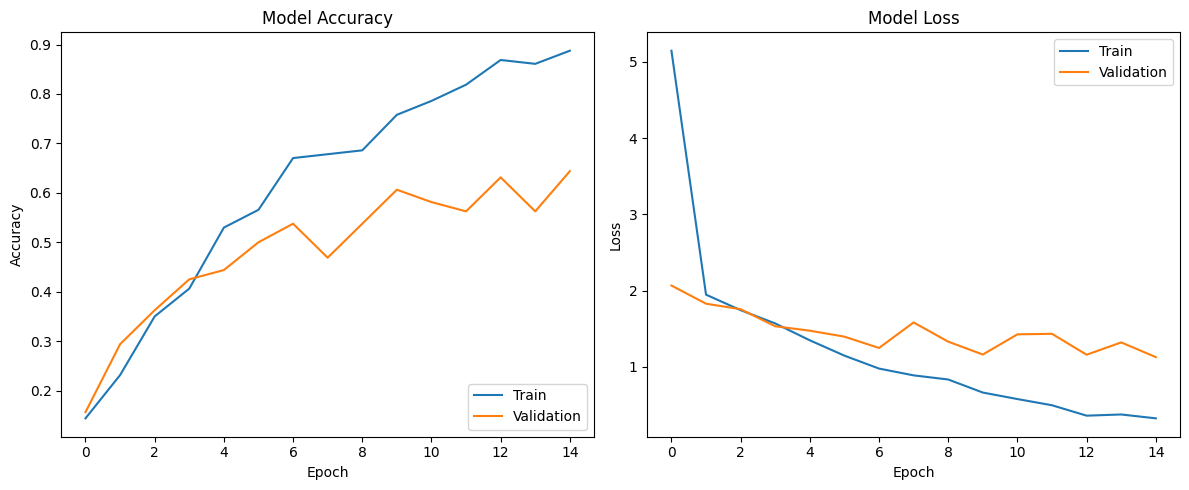

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step


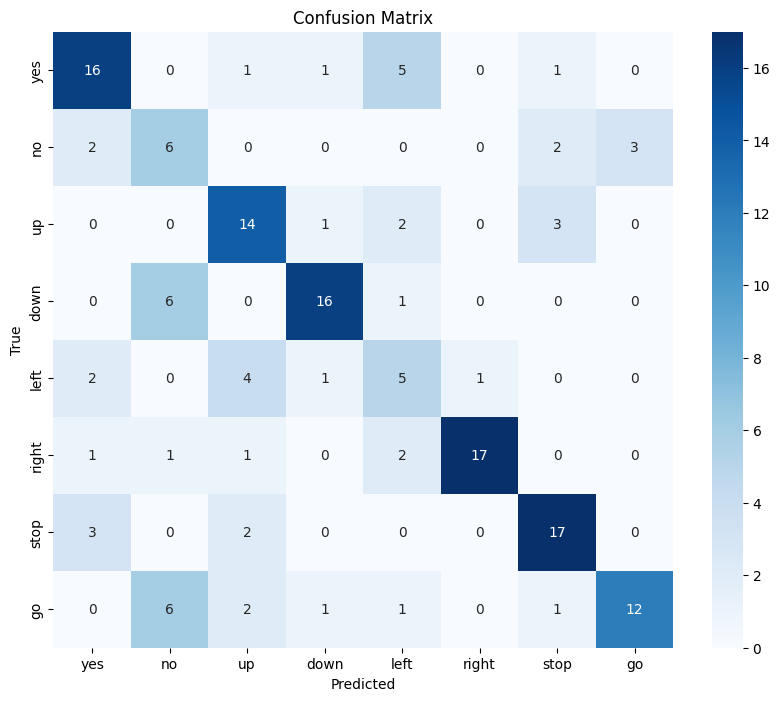

In [9]:
# Cell 13: Visualize training results
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing the Model
Testing our trained model with new audio samples to verify recognition accuracy across different voice commands.


Testing: speech_commands/yes/eb3f7d82_nohash_4.wav (True class: yes)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


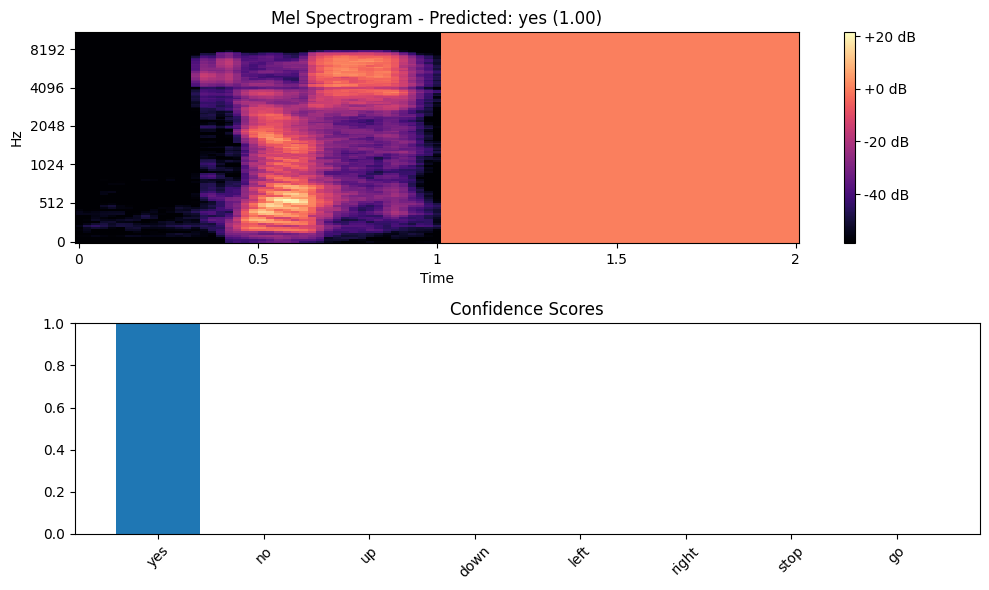

Predicted: yes with confidence 1.0000
Correct: ✓

Testing: speech_commands/no/bd061bef_nohash_1.wav (True class: no)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


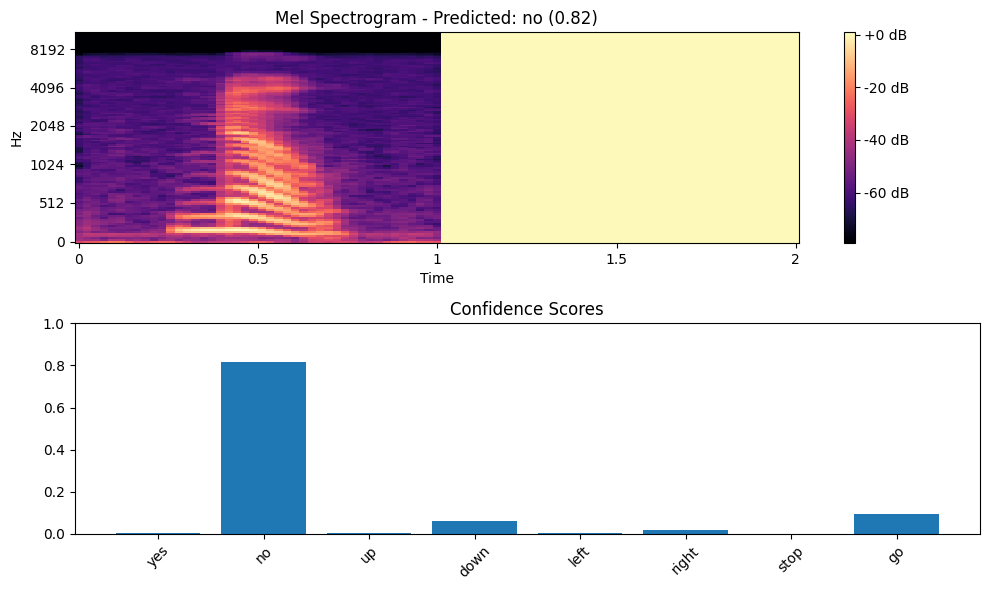

Predicted: no with confidence 0.8184
Correct: ✓

Testing: speech_commands/up/bd061bef_nohash_1.wav (True class: up)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


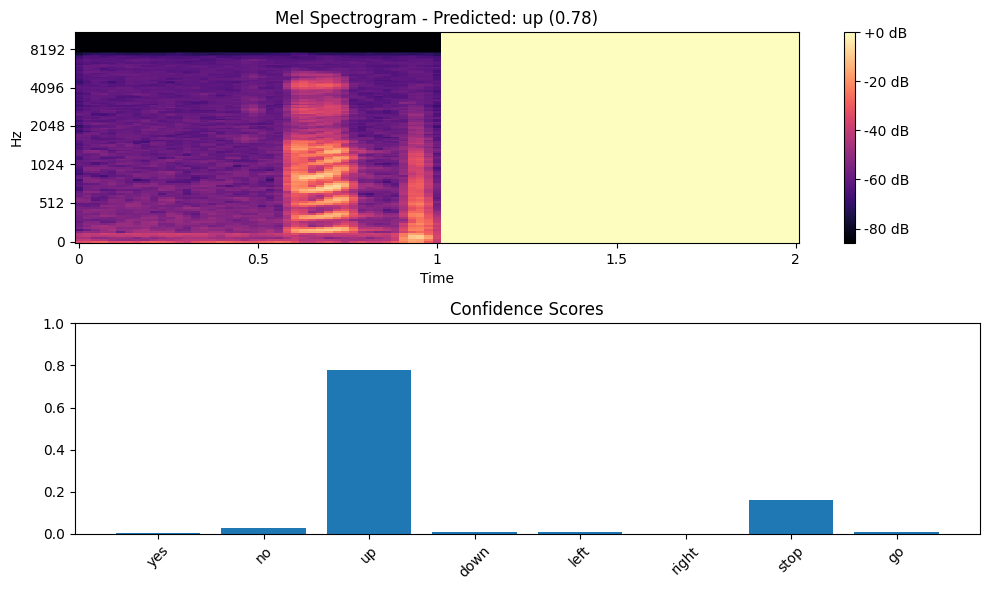

Predicted: up with confidence 0.7807
Correct: ✓


In [10]:
# Cell 15: Test the model with new audio samples
def predict_audio_class(file_path, model, class_names):
    # Extract features
    features = extract_fixed_features(file_path)

    if features is not None:
        # Reshape for model input
        features = features.reshape(1, features.shape[0], features.shape[1], 1)

        # Make prediction
        predictions = model.predict(features)[0]
        predicted_class_index = np.argmax(predictions)
        predicted_class = class_names[predicted_class_index]
        confidence = predictions[predicted_class_index]

        # Display the spectrogram
        plt.figure(figsize=(10, 6))

        # Plot spectrogram
        plt.subplot(2, 1, 1)
        librosa.display.specshow(
            features[0, :, :, 0],
            x_axis='time',
            y_axis='mel',
            sr=22050,
            hop_length=512
        )
        plt.title(f"Mel Spectrogram - Predicted: {predicted_class} ({confidence:.2f})")
        plt.colorbar(format='%+2.0f dB')

        # Plot confidence scores
        plt.subplot(2, 1, 2)
        plt.bar(class_names, predictions)
        plt.ylim(0, 1)
        plt.title('Confidence Scores')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return predicted_class, confidence, predictions

    return None, None, None

# Test with sample audio files
test_files = []
for class_name in selected_classes:
    # Get one file from each class
    file_path = glob.glob(f"speech_commands/{class_name}/*.wav")[0]
    test_files.append((file_path, class_name))

# Test a few samples
for file_path, true_class in test_files[:3]:  # Test first 3 samples
    print(f"\nTesting: {file_path} (True class: {true_class})")
    predicted_class, confidence, _ = predict_audio_class(file_path, model, selected_classes)

    if predicted_class is not None:
        print(f"Predicted: {predicted_class} with confidence {confidence:.4f}")
        print(f"Correct: {'✓' if predicted_class == true_class else '✗'}")

## Model Export
Saving our model in multiple formats for deployment in different platforms, similar to Teachable Machine's export options.

In [12]:
# Cell 17: Export the model for deployment
# Install tensorflowjs if not available
!pip install -q tensorflowjs

# Save the model in different formats
# 1. Keras H5 format
model.save('audio_classifier_model.h5')

# 2. TensorFlow.js format
import tensorflowjs as tfjs
!mkdir -p tfjs_audio_model
tfjs.converters.save_keras_model(model, 'tfjs_audio_model')

# 3. Save class names
import json
with open('tfjs_audio_model/class_names.json', 'w') as f:
    json.dump(selected_classes, f)

print("Model exported in the following formats:")
print("1. Keras H5: audio_classifier_model.h5")
print("2. TensorFlow.js: tfjs_audio_model/")
print("3. Class names: tfjs_audio_model/class_names.json")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model exported in the following formats:
1. Keras H5: audio_classifier_model.h5
2. TensorFlow.js: tfjs_audio_model/
3. Class names: tfjs_audio_model/class_names.json


In [13]:
import os
import shutil
import zipfile
from google.colab import files

# Path to the folder you want to download
folder_path = 'tfjs_audio_model'

# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Error: The folder '{folder_path}' does not exist.")
else:
    # Create a zip file of the folder
    zip_filename = f"{folder_path}.zip"

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through all files in the directory
        for root, dirs, filenames in os.walk(folder_path):
            for filename in filenames:
                # Create the full filepath
                file_path = os.path.join(root, filename)
                # Add file to the zip file
                # The arcname parameter specifies the path in the zip file
                zipf.write(file_path, arcname=os.path.relpath(file_path, os.path.dirname(folder_path)))

    # Download the zip file
    files.download(zip_filename)
    print(f"Downloaded '{folder_path}' as '{zip_filename}'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 'tfjs_audio_model' as 'tfjs_audio_model.zip'.
